In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from typing import List
import math
import pandas as pd
import matplotlib.pyplot as plt
from dataclasses import dataclass

In [3]:

# define the hyperparameters

@dataclass
class Config:
    n_embd: int = 384
    n_head: int = 6
    n_layer: int = 6
    n_vocab: int = 256
    block_size: int = 256
    batch_size: int = 64
    max_iters: int = 10000
    eval_interval: int = 100
    learning_rate: float = 1e-4
    device: str = "cuda" if torch.cuda.is_available() else "cpu"
    eval_iters: int = 200
    dropout: float = 0.2
    bias: bool = True
    

GPT_config = Config()

batch_size = GPT_config.batch_size
block_size = GPT_config.block_size
max_iters = GPT_config.max_iters # set the number of training iterations as you like
eval_interval = GPT_config.eval_interval
learning_rate = GPT_config.learning_rate
device = "cuda" if torch.cuda.is_available() else "cpu"
eval_iters = GPT_config.eval_iters
n_embd = GPT_config.n_embd
n_heads = GPT_config.n_head
n_layers = GPT_config.n_layer
dropout = GPT_config.dropout
bias = GPT_config.bias

df = pd.DataFrame(columns=['iter', 'train_loss', 'val_loss'])
filename = "../data/input.txt"
modelname = "../output/GPT.pt"
loss_fn = "../output/loss_GPT.png"

In [4]:
# read the dataset
with open(filename, "r", encoding="utf-8") as f:
    text = f.read()
chars = sorted(list(set(text)))

class char_tokenizer:
    """
    a very simple char-based tokenizer. the tokenizer turns a string into a list of integers.
    """

    def __init__(self, corpus: List[str]):
        self.corpus = corpus
        # TODO: calculate the vocab size and create a dictionary that maps each character to a unique integer
        self.n_vocab = len(corpus)
        self.ix_to_char = corpus
        self.char_to_ix = {char: i for i, char in enumerate(corpus)}
        # End of your code

    def encode(self, string: str):
        # TODO: convert a string into a list of integers and return, using the dictionary you created above
        return [self.char_to_ix[char] for char in string]
        # End of your code
 
    def decode(self, codes: List[int]):
        # TODO: convert a list of integers into a string and return, using the dictionary you created above
        return ''.join([self.ix_to_char[i] for i in codes])
        # End of your code

# initialize the vocabulary
tokenizer = char_tokenizer(chars)
encode = tokenizer.encode
decode = tokenizer.decode
n_vocab = tokenizer.n_vocab
GPT_config.n_vocab = n_vocab

# separate the dataset into train and validation
train_data = torch.tensor(encode(text[: -len(text) // 10]), dtype=torch.long)
val_data = torch.tensor(encode(text[-len(text) // 10 :]), dtype=torch.long)

In [5]:
class Head(nn.Module):
    """single head of self-attention"""
    def __init__(self, config):
        super().__init__()
        # TODO: create three linear layers, Key, Query, and Value, each of which maps from n_embd to head_size
        #       and assign them to self.Key, self.Query, and self.Value, respectively
        head_size = config.n_embd // config.n_head
        self.Key = nn.Linear(config.n_embd, head_size)
        self.Query = nn.Linear(config.n_embd, head_size)
        self.Value = nn.Linear(config.n_embd, head_size)
        self.head_size = head_size
        self.attn_dropout = nn.Dropout(config.dropout)
        # End of your code
        self.register_buffer("tril", torch.tril(torch.ones(block_size, block_size)))


    def forward(self, inputs):
        # TODO: implement the forward function of the head
        #       the input is a tensor of shape (batch, time, n_embd)
        #       the output should be a tensor of shape (batch, time, head_size)
        #       you may use the tril buffer defined above to mask out the upper triangular part of the affinity matrix

        key = self.Key(inputs)
        query = self.Query(inputs)
        value = self.Value(inputs)

        scores = torch.matmul(query, key.transpose(-1, -2)) / math.sqrt(self.head_size)

        # Get the time dimension size from the inputs tensor
        time_size = inputs.shape[1]

        # Create a tril tensor dynamically based on the time dimension size
        tril = torch.tril(torch.ones(time_size, time_size, device=inputs.device))

        # Apply the dynamic mask to the scores tensor
        scores = scores * tril - 1e12 * (1 - tril)

        # Compute the softmax of the scores
        attn_weights = torch.softmax(scores, dim=-1)
        
        attn_weights = self.attn_dropout(attn_weights)

        # Compute the weighted sum of the value matrix using the attention weights
        out = torch.matmul(attn_weights, value)

        # Output is a tensor of shape (batch, time, head_size)
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        #TODO: implement heads and projection
        assert config.n_embd % config.n_head == 0
        head_size = config.n_embd // config.n_head
        self.heads = nn.ModuleList([Head(config) for _ in range(config.n_head)])
        self.projection = nn.Linear(config.n_embd, config.n_embd)
        self.resid_dropout = nn.Dropout(dropout)

        # End of your code
    def forward(self, inputs):
        #TODO: implement the forward function of the multi-head attention
        
        out = torch.cat([head(inputs) for head in self.heads], dim=-1)
        out = self.projection(out)
        out = self.resid_dropout(out)
        return out 

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y

class FeedForward(nn.Module):
    def __init__(self, config):
        super().__init__()
        #TODO: implement the feed-forward network

        self.net = nn.Sequential(
            nn.Linear(config.n_embd, 4 * config.n_embd),
            nn.GELU(),
            nn.Linear(4 * config.n_embd, config.n_embd),
            nn.Dropout(config.dropout)
        )
        
        # End of your code

    def forward(self, inputs):
        return self.net(inputs)

class Block(nn.Module):
    def __init__(self, config):
        super().__init__()
        # TODO: implement the block of transformer using the MultiHeadAttention and 
        # FeedForward modules, along with the layer normalization layers
        self.attention = CausalSelfAttention(config)
        self.norm1 = nn.LayerNorm(config.n_embd)
        self.ff = FeedForward(config)
        self.norm2 = nn.LayerNorm(config.n_embd)
        
        # End of your code
    def forward(self, x):
        #TODO: implement the forward function of the block, you may refer to the docs of this experiment
        x = self.attention(self.norm1(x)) + x
        x = self.ff(self.norm2(x)) + x        
        # End of your code
        return x

class Transformer(nn.Module):
    def __init__(self, config):
        super().__init__()
        # TODO: create the embedding table, the stack of blocks, the layer normalization layer, 
        # and the linear layers.
        self.config = config
        self.wte = nn.Embedding(config.n_vocab, config.n_embd)
        self.wpe = nn.Embedding(config.block_size, config.n_embd)
        self.blocks = nn.Sequential(*[Block(config) for _ in range(config.n_layer)])
        self.ln_f = nn.LayerNorm(config.n_embd)
        self.lm_head = nn.Linear(config.n_embd, config.n_vocab)
        self.dropout = nn.Dropout(config.dropout)
        self.softmax = nn.Softmax(dim=-1)
        # End of your code
    def get_positional_embeddings(self, inputs):
        seq_len = inputs.size(1)
        position = torch.arange(0, seq_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, self.config.n_embd, 2).float() * (-math.log(10000.0) / self.config.n_embd))
        pos_enc = torch.zeros(1, seq_len, self.config.n_embd)
        pos_enc[0, :, 0::2] = torch.sin(position * div_term)
        pos_enc[0, :, 1::2] = torch.cos(position * div_term)
        return pos_enc.to(inputs.device)
    
    def forward(self, inputs, labels=None):
        # TODO: implement the forward function of the transformer

        # inputs:(batch, context)

        # embedding:(batch, context, embedding)
        # embedding = self.wte(inputs)+self.get_positional_embeddings(inputs)
        pos = torch.arange(0, inputs.size(1), dtype=torch.long, device=self.config.device)
        embedding = self.wte(inputs)+self.wpe(pos)
        embedding = self.dropout(embedding)
        # attens:(batch, context, embedding)
        attens = self.blocks(embedding)
        # attens:(batch, context, embedding)
        attens = self.ln_f(attens)
        # logits:(batch, context, attens)
        logits = self.lm_head(attens)
        # End of your code

        # compute the loss
        
        if labels is None:
            loss = None
        else:
            batch, time, channel = logits.shape
            logits = logits.view(batch * time, channel)
            labels = labels.view(batch * time)
            loss = F.cross_entropy(logits, labels)
        return logits, loss

    def generate(self, inputs, max_new_tokens):
        generated_tokens = []
        context_length = inputs.size(1)

        for _ in range(max_new_tokens):
            # Truncate the input sequence to keep the same length
            if inputs.size(1) > self.config.block_size:
                inputs = inputs[:, -self.config.block_size:]
            logits, _ = self.forward(inputs)
            probabilities = F.softmax(logits[:, -1, :], dim=-1)
            new_token = torch.multinomial(probabilities, num_samples=1)
            generated_tokens.append(new_token)
            inputs = torch.cat((inputs, new_token), dim=1)            
        return torch.cat(generated_tokens, dim=1)
    


In [6]:
def get_batch(split):
    data = train_data if split == "train" else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i : i + block_size] for i in ix])
    y = torch.stack([data[i + 1 : i + block_size + 1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y


@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ["train", "val"]:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            x, y = get_batch(split)
            logits, loss = model(x, y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out


def generate(model):
    context = torch.zeros((1, 1), device=device, dtype=torch.long)
    print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))

def myGenerate(model):
    text = "I would I were a Roman; "
    context = torch.tensor(encode(text),device=device, dtype=torch.long)
    context = torch.stack([context])
    print(text,decode(model.generate(context, max_new_tokens=200)[0].tolist()))


def train(model):
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    best_eval = float('inf')
    for iter in range(max_iters):
        
        if iter % eval_interval == 0:
            losses = estimate_loss(model)
            if iter % (eval_interval*2)==0:
                print(
                    f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
                )
            df.loc[len(df)] = [iter, losses['train'].item(), losses['val'].item()]
            if losses["val"] < best_eval:
                best_eval = losses["val"]
                torch.save(model.state_dict(), modelname)

        inputs, labels = get_batch("train")

        logits, loss = model(inputs, labels)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()
        
def draw(df):
    x = [i*eval_interval for i in range(len(df))]
    plt.plot(df['iter'], df['train_loss'], label='train_loss')
    plt.plot(df['iter'], df['val_loss'], label='val_loss')
    plt.legend()
    plt.show()

In [12]:
model = Transformer(config=GPT_config).to(device)
train(model)

step 0: train loss 4.2948, val loss 4.2960
step 200: train loss 2.4647, val loss 2.4802
step 400: train loss 2.3791, val loss 2.3988
step 600: train loss 2.2020, val loss 2.2403
step 800: train loss 2.0219, val loss 2.0892
step 1000: train loss 1.9043, val loss 2.0086
step 1200: train loss 1.8073, val loss 1.9379
step 1400: train loss 1.7303, val loss 1.8796
step 1600: train loss 1.6661, val loss 1.8283
step 1800: train loss 1.6137, val loss 1.7879
step 2000: train loss 1.5717, val loss 1.7535
step 2200: train loss 1.5366, val loss 1.7241
step 2400: train loss 1.5037, val loss 1.6958
step 2600: train loss 1.4710, val loss 1.6796
step 2800: train loss 1.4419, val loss 1.6523
step 3000: train loss 1.4186, val loss 1.6305
step 3200: train loss 1.3977, val loss 1.6261
step 3400: train loss 1.3750, val loss 1.6032
step 3600: train loss 1.3556, val loss 1.5959
step 3800: train loss 1.3381, val loss 1.5776
step 4000: train loss 1.3212, val loss 1.5775
step 4200: train loss 1.3020, val loss 1.

In [13]:
myGenerate(model)

I would I were a Roman;  we weary here,
That blessing withal. Three thwarten to sit
Thy sweetest queen's burthen's and ne'er day fer;
Changil'd it set it on your throne again
To an add pace 't and yourself.

COMINIUS:
Where i


In [14]:
df.to_csv('loss.csv', index=False)

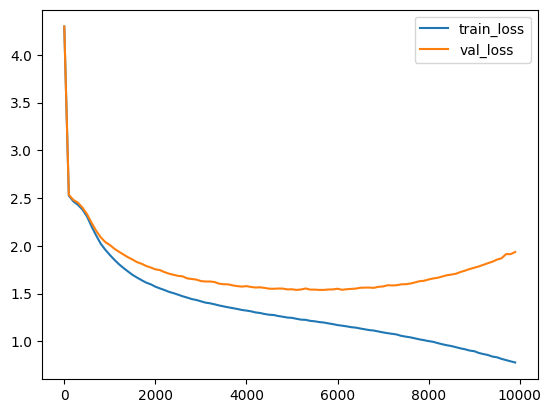

In [15]:
draw(df)

In [9]:
model = Transformer(config=GPT_config).to(device)
model.load_state_dict(torch.load(modelname))
generate(model)

Ehash dris, sit-t Aftem Eadurin.
Thus, waraichoun layoy:---fooe, poubes:
Sa-he't? wis keane, conf Peatit's tetencol,
For mybrin a sakesw arin suight, pee
Co tue leipte, ubetw anin wle.
stond, iorderur
ate t; thoonds,--n wiwButigh theanstselly. What gorearingr ks etreawfomy:
Mast wile,
Towo well ttreforiedow! Teelely, whaillawed, hop igitils, n
utwh but allligrdo-dy'd catede, pulassap bumknacue towede
thent paimpdingnty yeneavele
sent menowsch Indenogm, at inspinhell morsw! I'vell s tongle
Buth s


In [10]:
myGenerate(model)

I would I were a Roman;  mat ity owero:
But ma itaindOed w'st covetingl, wacoumen oran.

ADiss the ballmatind teremes. umrandffedingeny duf?


CClolInth, i'e iclomand; ny, ay, arevewersed neforovil. bewly funer
mewwal:
'scust
